# Information
This notebook is meant to guide through the process of generating midi files. The steps are as follows:
* Extract data
* Preprocess data
* Build model
* Train model
* Assess results

Dependencies:
* Python 3.7
* Jupyter Notebook 4.4.0
* Keras 2.2.2
* Pretty Midi 0.2.8
* Matplotlib 2.2.2

# Global imports

In [1]:
from utils import *
import matplotlib.pyplot as plt
import numpy as np
import os

# Constants
Used for midi file frequency and sample length.

In [2]:
FS     = 16     # Sampling rate
LENGTH = 128    # Number of time steps per sample

# Visualization & Extraction

The shape of the midi file (1948, 128)


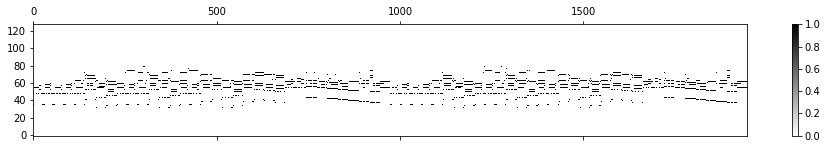

In [3]:
# Visualize a midi file

FILE_PATH = 'datasets/zelda/darkwrld.mid'


%matplotlib inline
midi_data = pretty_midi.PrettyMIDI(FILE_PATH)

mat = generate_combine_piano_roll(midi_data, FS)
print("The shape of the midi file", mat.shape)
cax = plt.matshow(mat.T, aspect="auto", vmin=0, vmax=1, cmap="gray_r")
plt.colorbar(cax)
plt.gca().invert_yaxis()
plt.show()

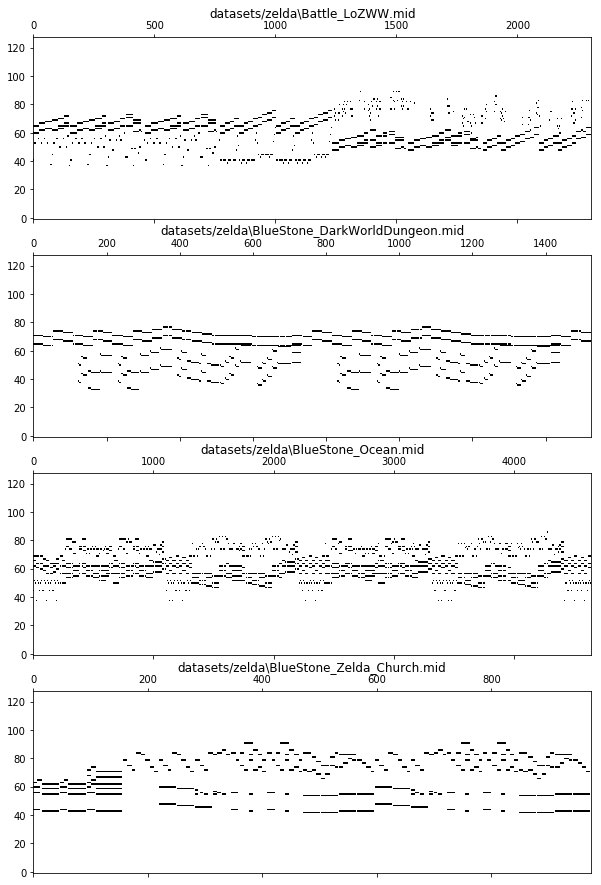

In [4]:
# Visualize all the training data

DIRECTORY = "datasets/zelda"
LIMIT = 5 # Controls how many training samples to show


%matplotlib inline
data = []
fig = plt.figure(figsize=(10, 67 * 4))
i = 1
for filename in os.listdir(DIRECTORY):
    if filename.endswith(".mid"):
        fn = os.path.join(DIRECTORY, filename)
        midi_data = pretty_midi.PrettyMIDI(fn)
        mat = generate_combine_piano_roll(midi_data, FS)
        if mat is None: continue
        ax = fig.add_subplot(67, 1, i)
        ax.matshow(mat.T, aspect="auto", vmin=0, vmax=1, cmap="gray_r")
        plt.gca().invert_yaxis()
        ax.set_title(fn, y=1.08)
        i += 1
        if i >= LIMIT: break
plt.show()

# Data preprocessing

In [5]:
import warnings

DIRECTORY = "zelda" 
NUM_SAMPLES = 2000


data = []
c_samples = 0
for filename in os.listdir(DIRECTORY):
    if filename.endswith(".mid"): 
        fn = os.path.join(DIRECTORY, filename)
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                midi_data = pretty_midi.PrettyMIDI(fn)
        except:
            continue
        mat = generate_combine_piano_roll(midi_data, FS)
        if mat is None: continue
        samples = split_sample(mat, LENGTH)
        filtered_samples = []
        for sample in samples:
            if np.count_nonzero(sample) > 0:
                filtered_samples.append(np.expand_dims(sample, axis=0))
        filtered_samples = np.vstack(filtered_samples)
        data.append(filtered_samples)
        c_samples += len(filtered_samples)
        print(len(filtered_samples), " samples from '", fn, "'")
        if c_samples >= NUM_SAMPLES: break
data = np.vstack(data)
data = data[0:NUM_SAMPLES]

print("Data shape: ", data.shape)

18  samples from ' datasets/zelda\Battle_LoZWW.mid '
11  samples from ' datasets/zelda\BlueStone_DarkWorldDungeon.mid '
36  samples from ' datasets/zelda\BlueStone_Ocean.mid '
7  samples from ' datasets/zelda\BlueStone_Zelda_Church.mid '
7  samples from ' datasets/zelda\chase_theme.mid '
9  samples from ' datasets/zelda\clocktower.mid '
6  samples from ' datasets/zelda\Clock_Town_Day_1-Piano.mid '
15  samples from ' datasets/zelda\darkwrld.mid '
26  samples from ' datasets/zelda\ETPV.mid '
3  samples from ' datasets/zelda\fairy.mid '
16  samples from ' datasets/zelda\Farewell_Hyrule_King_pedal-added.mid '
6  samples from ' datasets/zelda\Fencing_Instruction_Piano.mid '
23  samples from ' datasets/zelda\ForestTemple.mid '
4  samples from ' datasets/zelda\Forsaken_Fortress_Invasion_2_Piano.mid '
6  samples from ' datasets/zelda\Forsaken_Fortress_Invasion_Piano.mid '
11  samples from ' datasets/zelda\Forsaken_Fortress_Piano.mid '
7  samples from ' datasets/zelda\Ganon.mid '
9  samples fro

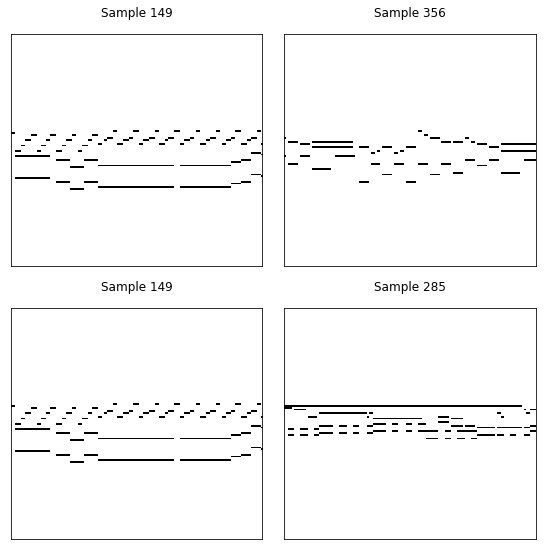

In [6]:
# Visualize a few random samples from our preprocessed data
%matplotlib inline
from matplotlib.pyplot import cm
fig = plt.figure(figsize=(6,6))
cax = None
for i in range(4):
    ax = fig.add_subplot(2, 2, i+1)
    rand_idx = np.random.randint(0, len(data))
    cax = ax.matshow(data[rand_idx].T, aspect="auto", vmin=0, vmax=1, cmap="gray_r")
    ax.set_title("Sample %d" % rand_idx)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_ylim(ax.get_ylim()[::-1])
fig.tight_layout(pad=-5., w_pad=1.5, h_pad=1.5)

# Define the model

In [21]:
from keras.layers.merge import _Merge
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, MaxPooling2D
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import RMSprop, Adam
from functools import partial

import keras.backend as K

import sys

Using TensorFlow backend.


In [223]:
class GAN():
    def __init__(self, img_rows, img_cols, channels, batch_size):
        # Input shape
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channels = channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        
        self.batch_size = batch_size

    def build_generator(self):

        model = Sequential()
        
        model.add(Dense(64 * 16 * 16, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((16, 16, 64)))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization())
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(32, kernel_size=3, padding="same"))
        model.add(BatchNormalization())
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(16, kernel_size=3, padding="same"))
        model.add(BatchNormalization())
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        
        model.add(Activation("sigmoid"))

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img), model

    def build_discriminator(self, final_activation='sigmoid'):
        model = Sequential()
        
        model.add(Conv2D(14, kernel_size=(2,128), strides=2, input_shape=self.img_shape))
        model.add(ReLU())
        model.add(Dropout(0.2))
        
        model.add(Conv2D(77, kernel_size=(4,1), strides=2, padding="same"))
        model.add(ReLU())
        model.add(Dropout(0.2))
        
        model.add(Flatten())
        model.add(Dense(512, activation="relu"))
        
        model.add(Dense(1, activation=final_activation))

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity), model
    
    def generate(self, noise=None, n_images=1):
        if noise is None:
            noise = np.random.normal(0, 1, (n_images, self.latent_dim))
        
        gen_imgs = self.generator.predict(noise)
        gen_imgs[gen_imgs < 0.5] = 0 # Remove some notes
        gen_imgs[gen_imgs > 0] = 1 # Binarize the rest
        return np.squeeze(gen_imgs)


In [224]:
class DCGAN(GAN):
    def __init__(self, img_rows, img_cols, channels, batch_size):
        super().__init__(img_rows, img_cols, channels, batch_size)

        optimizer = Adam(0.0002, 0.5, 0.999)

        # Build and compile the discriminator
        self.discriminator, self.raw_discriminator = self.build_discriminator(final_activation='sigmoid')
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)

        # Build the generator
        self.generator, self.raw_generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        self.latest_history = None
    
    def summary(self):
        print("Discriminator model")
        self.discriminator.get_layer(index=1).summary()
        print("Generator model")
        self.generator.get_layer(index=1).summary()
        
    def load_weights(self, dir_name):
        gen_fn = dir_name + '/generator.h5'
        disc_fn = dir_name + '/discriminator.h5'
        import os.path
        if not os.path.isfile(gen_fn):
            print("File ", comb_fn, " was not found!")
            return
        elif not os.path.isfile(disc_fn):
            print("File ", disc_fn, " was not found!")
            return
        from keras.models import load_model
        self.raw_generator.load_weights(gen_fn)
        self.raw_discriminator.load_weights(disc_fn)

    def train(self, X_train, epochs, save_interval=500, plot_interval=100):
        # Adversarial ground truths - Using inversed labels for more stable training
        valid = np.zeros((self.batch_size, 1))
        fake = np.ones((self.batch_size, 1))
        
        # Track losses for plotting
        d_losses_real = []
        d_losses_fake = []
        g_losses = []
        epoch_list = []
        predictions = []
        
        # Setup saveing figure and axis
        %matplotlib inline
        save_fig, save_ax = plt.subplots(nrows=1, ncols=1)
        
        # Setup figure to be updatable
        %matplotlib notebook
        fig = plt.figure(figsize=(8, 12))
        ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=2, fig=fig)
        ax2 = plt.subplot2grid((3, 2), (1, 0), colspan=2, fig=fig)
        ax3 = plt.subplot2grid((3, 2), (2, 0), fig=fig)
        ax4 = plt.subplot2grid((3, 2), (2, 1), fig=fig)
        fig.tight_layout(rect=[0, 0.03, 1, 0.95])
        fig.show()
        fig.canvas.draw()
        latest_img_1 = None
        latest_img_2 = None
        
        def plot_info(f, a1, a2, a3, a4, epoch):
            # Losses
            a1.clear()
            a1.plot(epoch_list, d_losses_real, label="Real")
            a1.plot(epoch_list, d_losses_fake, label="Fake")
            a1.legend()
            a1.set_title("Discriminator losses over time")
            a1.legend()

            a2.clear()
            a2.plot(epoch_list, g_losses)
            a2.set_title("Generator loss over time")

            a3.clear()
            a3.matshow(latest_img_1, aspect="auto", vmin=0, vmax=1, cmap="gray_r")
            a3.set_title("Generated image at epoch %d" % epoch)
            a3.set_ylim(a3.get_ylim()[::-1])

            a4.clear()
            a4.matshow(latest_img_2, aspect="auto", vmin=0, vmax=1, cmap="gray_r")
            a4.set_title("Generated image at epoch %d" % epoch)
            a4.set_ylim(a4.get_ylim()[::-1])
            f.suptitle("Iteration %d" % epoch)

        for epoch in range(1, epochs+1):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select random batch
            idx = np.random.randint(0, X_train.shape[0], self.batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (self.batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)
            if epoch == 1 or epoch % 100 == 0:
                predictions.append(gen_imgs[0].squeeze())
        
            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            d_losses_real.append(d_loss_real)
            d_losses_fake.append(d_loss_fake)
            g_losses.append(g_loss)
            epoch_list.append(epoch)
            if epoch % plot_interval == 0:
                latest_img_1 = gen_imgs[0].squeeze().T
                latest_img_2 = gen_imgs[1].squeeze().T

                if epoch % save_interval == 0:
                    # Save a snapshot (png+midi)
                    save_ax.clear()
                    cax = save_ax.matshow(latest_img_1, aspect="auto", vmin=0, vmax=1, cmap="gray_r")
                    save_fig.savefig("output/%d-pianoroll.png" % epoch)
                    piano_roll_to_midi(latest_img_1, "output/%d-pianoroll.mid" % epoch)
                
                # Plot live updates
                plot_info(fig, ax1, ax2, ax3, ax4, epoch)
                fig.canvas.draw()
                
                if epoch % save_interval == 0:
                    fig.savefig("output/%d-training.png" % epoch)
        
        # Final static plot of the training
        from IPython.display import clear_output
        clear_output()
        %matplotlib inline
        fig = plt.figure(figsize=(8, 12))
        ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=2, fig=fig)
        ax2 = plt.subplot2grid((3, 2), (1, 0), colspan=2, fig=fig)
        ax3 = plt.subplot2grid((3, 2), (2, 0), fig=fig)
        ax4 = plt.subplot2grid((3, 2), (2, 1), fig=fig)
        fig.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        plot_info(fig, ax1, ax2, ax3, ax4, epoch)
        
        fig.show()
        plt.show()
        
        # Save weights
        self.raw_generator.save_weights("output/generator.h5", overwrite=True)
        self.raw_discriminator.save_weights("output/discriminator.h5", overwrite=True)
        
        # Save history
        history = { 
            "discriminator_real_losses": d_losses_real, 
            "discriminator_fake_losses": d_losses_fake, 
            "generator_losses": g_losses, 
            "epochs": epoch_list,
            "predictions": predictions
        }
        self.latest_history = history
        np.save("output/history", history)

# Prepare data and train

In [236]:
# Prepare data
MAX_SAMPLES = 400
NUM_CHANNELS = 1  # channels are assumed to be singluar, other things need to be changed if this is increased

(n_samples, time_span, pitch_level) = data.shape
if n_samples > MAX_SAMPLES:
    n_samples = MAX_SAMPLES
train_data = data[0:n_samples].reshape(n_samples, time_span, pitch_level, NUM_CHANNELS)
print("Train data shape", train_data.shape, " out of available ", data.shape)

Train data shape (400, 128, 128, 1)  out of available  (820, 128, 128)


In [237]:
# Create model
dcgan = DCGAN(time_span, pitch_level, NUM_CHANNELS, batch_size=64)
dcgan.summary()
#dcgan.load_weights("weights") # Uncomment this to load weights from directory

Discriminator model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_180 (Conv2D)          (None, 64, 1, 14)         3598      
_________________________________________________________________
re_lu_62 (ReLU)              (None, 64, 1, 14)         0         
_________________________________________________________________
dropout_63 (Dropout)         (None, 64, 1, 14)         0         
_________________________________________________________________
conv2d_181 (Conv2D)          (None, 32, 1, 77)         4389      
_________________________________________________________________
re_lu_63 (ReLU)              (None, 32, 1, 77)         0         
_________________________________________________________________
dropout_64 (Dropout)         (None, 32, 1, 77)         0         
_________________________________________________________________
flatten_29 (Flatten)         (None, 2464)              0

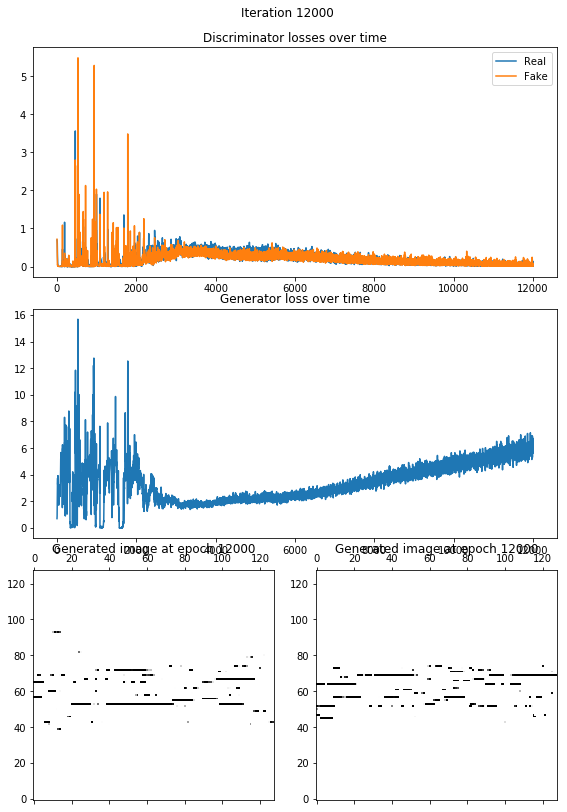

In [238]:
# Train
NUM_EPOCHS = 12000

dcgan.train(train_data, epochs=NUM_EPOCHS)

# Assess results
Plots and sample midi files are also creating during training under folder `output`.

Generated samples shape (4, 128, 128)


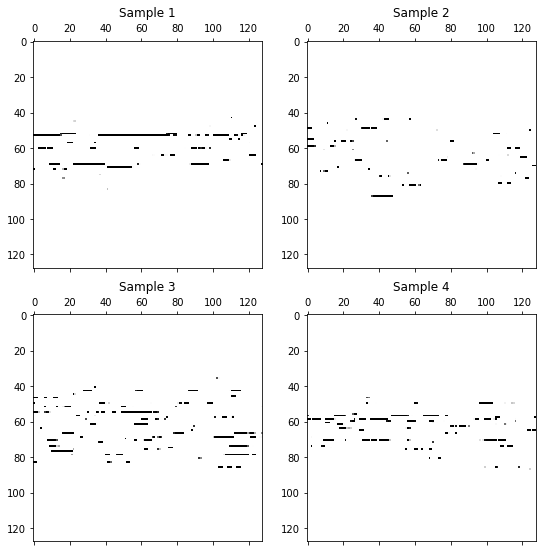

In [300]:
# Visualize a few random samples
%matplotlib inline
generated_samples = dcgan.generate(n_images=4)
print("Generated samples shape", generated_samples.shape)
fig = plt.figure(figsize=(6,6))
cax = None
for i in range(4):
    ax = fig.add_subplot(2, 2, i+1)
    cax = ax.matshow(generated_samples[i].T, aspect="auto", vmin=0, vmax=1, cmap="gray_r")
    ax.set_title("Sample %d" % (i+1), y=1.08)
fig.tight_layout(pad=-5., w_pad=1.5, h_pad=1.5)

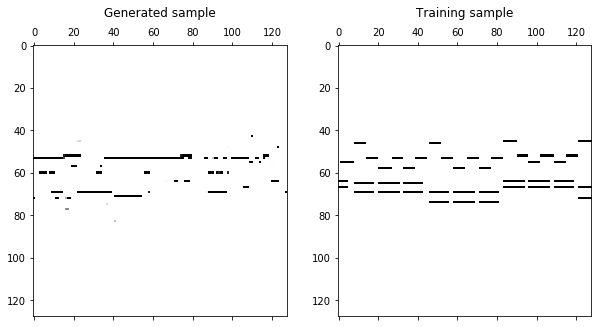

In [302]:
# Compare generated with a random training sample
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
cax = ax.matshow(generated_samples[0].T, aspect="auto", vmin=0, vmax=1, cmap="gray_r")
ax.set_title("Generated sample", y=1.08)
ax = fig.add_subplot(1, 2, 2)
cax = ax.matshow(data[300].T, aspect="auto", vmin=0, vmax=1, cmap="gray_r")
ax.set_title("Training sample", y=1.08);

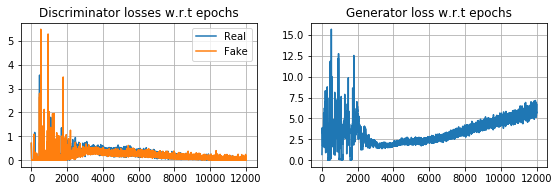

In [303]:
# Visualize history
hist = dcgan.latest_history
epoch_list = hist['epochs']
fig = plt.figure(figsize=(8, 3))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.clear()
ax1.plot(epoch_list, hist['discriminator_real_losses'], label="Real")
ax1.plot(epoch_list, hist['discriminator_fake_losses'], label="Fake")
ax1.legend()
ax1.set_title("Discriminator losses w.r.t epochs")
ax1.grid()

ax2.clear()
ax2.plot(epoch_list, hist['generator_losses'])
ax2.set_title("Generator loss w.r.t epochs")
ax2.grid()
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.show()

Predictions  121  with shapes (128, 128)
121


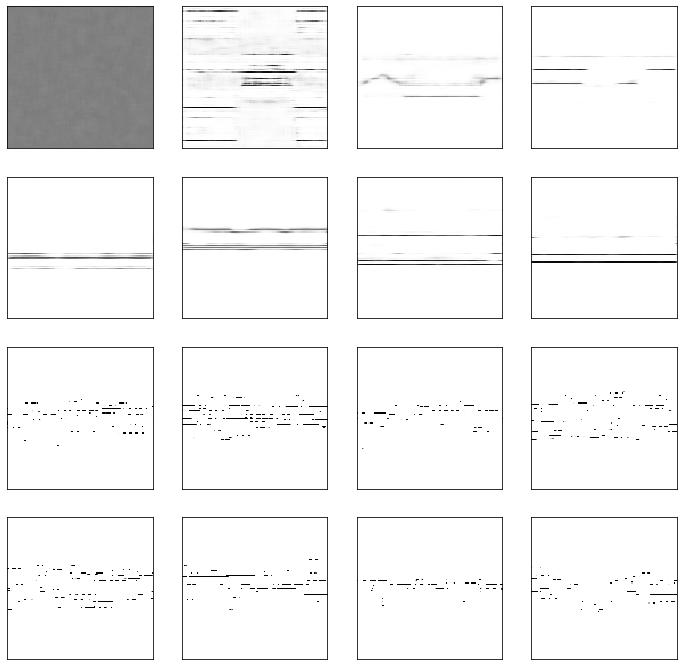

In [306]:
# Visualize some predictions along the way
%matplotlib inline
fig = plt.figure(figsize=(12, 12))
preds = dcgan.latest_history['predictions']
print("Predictions ", len(preds), " with shapes", preds[0].shape)
i = 0

def plot_row(data, nbr, n_rows, n_cols):
    for i in range(len(data)):
        idx = nbr * n_cols + i + 1
        ax = fig.add_subplot(n_rows, n_cols, idx)
        ax.matshow(data[i].T, aspect="auto", vmin=0, vmax=1, cmap="gray_r")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

n_preds = len(preds)
pred = preds[0:4]          # Plot the first 4 samples
plot_row(pred, 0, 4, 4)
pred = preds[10:14]        # Plot some later samples (change freely)
plot_row(pred, 1, 4, 4)
pred = preds[101:105]      # Plot even later samples (change freely)
plot_row(pred, 2, 4, 4)
pred = preds[n_preds-5:-1] # Plot the last 4 samples
plot_row(pred, 3, 4, 4)

In [307]:
# Metrics & evaluation
def get_num_pitch_used(pianoroll):
    """UPC - Return the number of unique pitches used in a piano-roll."""
    return np.sum(np.sum(pianoroll, 0) > 0)

def get_qualified_note_rate(pianoroll, threshold=2):
    """QN - Return the ratio of the number of the qualified notes (notes longer than
    `threshold` (in time step)) to the total number of notes in a piano-roll."""
    padded = np.pad(pianoroll.astype(int), ((1, 1), (0, 0)), 'constant')
    diff = np.diff(padded, axis=0)
    flattened = diff.T.reshape(-1,)
    onsets = (flattened > 0).nonzero()[0]
    offsets = (flattened < 0).nonzero()[0]
    num_qualified_note = (offsets - onsets >= threshold).sum()
    return num_qualified_note / len(onsets)

n_samples = len(train_data)
gen_samples = dcgan.generate(n_images=n_samples)
gen_npu = 0
gen_qnr = 0
for i in range(n_samples):
    s = gen_samples[i].squeeze()
    s[s < 0.5] = 0
    s[s > 0] = 1
    gen_npu += get_num_pitch_used(s)
    gen_qnr += get_qualified_note_rate(s)
gen_npu /= n_samples
gen_qnr /= n_samples

train_npu = 0
train_qnr = 0
for i in range(n_samples):
    s = train_data[i].squeeze()
    s[s < 0.5] = 0
    s[s > 0] = 1
    train_npu += get_num_pitch_used(s)
    train_qnr += get_qualified_note_rate(s)
train_npu /= n_samples
train_qnr /= n_samples

print("Result for %d samples" % n_samples)
print("Training\nNumber of pitches used:\t %.2f\nQualified note rate:\t %.2f" % (train_npu, train_qnr))
print("Generated\nNumber of pitches used:\t %.2f\nQualified note rate:\t %.2f" % (gen_npu, gen_qnr))

Result for 400 samples
Training
Number of pitches used:	 17.24
Qualified note rate:	 0.91
Generated
Number of pitches used:	 20.70
Qualified note rate:	 0.71
